<a href="https://colab.research.google.com/github/badl7/Forecasting_bus/blob/main/Forecasting_bus_demand_in_Banana_Republic_municipalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
# EDA Libraries:

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from pathlib import Path  
import random

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

# LSTM:

import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import RMSprop, SGD

# ARIMA Model:

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse


import itertools

import pickle
import warnings
warnings.filterwarnings('ignore')

In [179]:
BASE_FILE = "/content/drive/MyDrive/Forecasting_bus_demand/"
df = pd.read_csv(f"{BASE_FILE}municipality_bus_utilization.csv")
df.head()


,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [180]:
df.tail()

,timestamp,municipality_id,usage,total_capacity
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113
13069,2017-08-19 16:30:35,3,1189,1930


In [181]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


In [183]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
municipality_id,13070.0,4.500000,2.872391,0.0,2.0,4.5,7.0,9.0
usage,13070.0,876.002984,679.287109,11.0,403.0,692.0,1190.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,697.0,1974.5,2947.0,3893.0


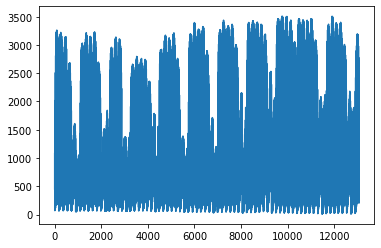

In [184]:
df['usage'].plot()

In [185]:
def max_of_hour(data):
  data = data.copy()
  data["timestamp"] = pd.to_datetime(data["timestamp"])
  
  data = data.groupby(['municipality_id', pd.Grouper(key='timestamp', freq='H')]).max()
  
  return data

In [186]:
# get the maximum values of bus usage per hour
df_max_per_hour = max_of_hour(df)
df_max_per_hour = df_max_per_hour.drop('total_capacity', axis=1)
df_max_per_hour

usage
municipality_id timestamp                 
0               2017-06-04 07:00:00    204
                2017-06-04 08:00:00    332
                2017-06-04 09:00:00    485
                2017-06-04 10:00:00    583
                2017-06-04 11:00:00    614
...                                    ...
9               2017-08-19 12:00:00    849
                2017-08-19 13:00:00    941
                2017-08-19 14:00:00    983
                2017-08-19 15:00:00    976
                2017-08-19 16:00:00    879

[6740 rows x 1 columns]

In [187]:
# convert timestamp column to datetime data type
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['date'] = df['timestamp'].dt.date

df_hour_size = df.groupby(['municipality_id', 'date', 'hour']).size().reset_index(name='counts')
df_hour_size

,municipality_id,date,hour,counts
0,0,2017-06-04,7,1
1,0,2017-06-04,8,2
2,0,2017-06-04,9,2
3,0,2017-06-04,10,2
4,0,2017-06-04,11,2
...,...,...,...,...
6735,9,2017-08-19,12,2
6736,9,2017-08-19,13,2
6737,9,2017-08-19,14,2
6738,9,2017-08-19,15,2


In [188]:
df_hour_size.counts.max()

6

In [189]:
# Min hour
df_min = df_hour_size.groupby('date')['hour'].min().reset_index(name='min_hour')

# Max hour
df_max = df_hour_size.groupby('date')['hour'].max().reset_index(name='max_hour')
df_min.max()

date        2017-08-19
min_hour             8
dtype: object

In [190]:
df_max.min()

date        2017-06-04
max_hour            16
dtype: object

In [191]:
df_filtre = df[(df['hour'] >=8) & (df['hour'] <= 16)]
df_filtre

,timestamp,municipality_id,usage,total_capacity,hour,date
10,2017-06-04 08:25:42,2,311,697,8,2017-06-04
11,2017-06-04 08:25:42,9,487,1332,8,2017-06-04
12,2017-06-04 08:25:42,6,687,3113,8,2017-06-04
13,2017-06-04 08:25:42,7,789,2019,8,2017-06-04
14,2017-06-04 08:25:42,4,1476,3893,8,2017-06-04
...,...,...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697,16,2017-08-19
13066,2017-08-19 16:30:35,8,1193,2947,16,2017-08-19
13067,2017-08-19 16:30:35,7,1354,2019,16,2017-08-19
13068,2017-08-19 16:30:35,6,1680,3113,16,2017-08-19


In [192]:
df_filtre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12810 entries, 10 to 13069
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        12810 non-null  datetime64[ns]
 1   municipality_id  12810 non-null  int64         
 2   usage            12810 non-null  int64         
 3   total_capacity   12810 non-null  int64         
 4   hour             12810 non-null  int64         
 5   date             12810 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 700.5+ KB


In [193]:
df_filtre.describe().T

,count,mean,std,min,25%,50%,75%,max
municipality_id,12810.0,4.500000,2.872393,0.0,2.0,4.5,7.00,9.0
usage,12810.0,884.672756,681.942912,11.0,406.0,703.0,1196.75,3508.0
total_capacity,12810.0,1972.800000,1144.075670,397.0,697.0,1974.5,2947.00,3893.0
hour,12810.0,11.911007,2.538463,8.0,10.0,12.0,14.00,16.0


In [194]:
def per_plot(data, feature=[]):
  data = data.copy()
  
  per_plot = data.groupby(feature[0])[feature[1]].sum().reset_index()

  fig, ax = plt.subplots(figsize = (10,8))
  sns.barplot(per_plot[feature[0]], per_plot[feature[1]], color='orange')

  ax.set(xlabel = f"{feature[0]}", ylabel = f"Sum of {feature[1]}", title = f"Total {feature[1]} Per {feature[0]}")
  sns.despine()

  return per_plot

,date,usage
0,2017-06-04,170503
1,2017-06-05,171854
2,2017-06-06,165668
3,2017-06-07,155895
4,2017-06-08,114807
...,...,...
67,2017-08-15,178511
68,2017-08-16,159068
69,2017-08-17,157445
70,2017-08-18,145982


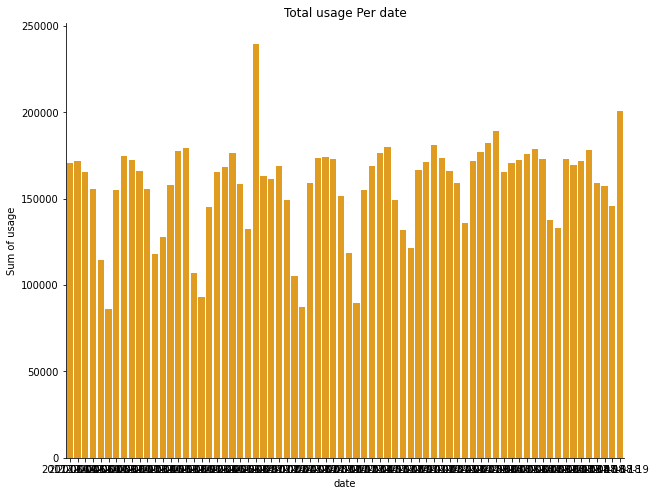

In [195]:
per_plot(df_filtre, feature=["date","usage"])

,municipality_id,total_capacity
0,0,3603453
1,1,508557
2,2,892857
3,3,2472330
4,4,4986933
5,5,751947
6,6,3987753
7,7,2586339
8,8,3775107
9,9,1706292


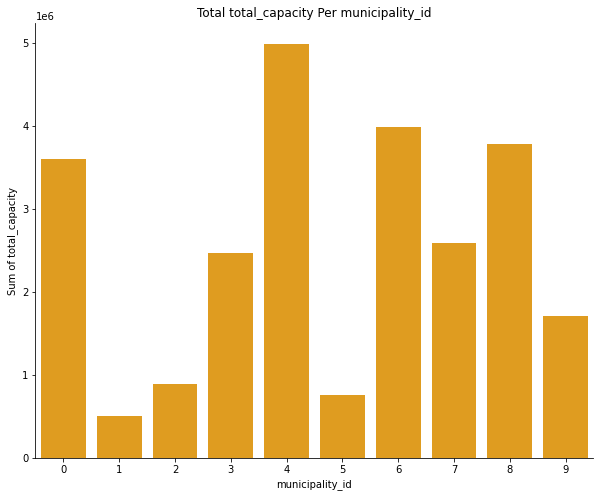

In [196]:
per_plot(df_filtre, feature=["municipality_id","total_capacity"])

,hour,usage
0,8,749895
1,9,1053726
2,10,1202925
3,11,1401526
4,12,1439394
5,13,1561912
6,14,1510362
7,15,1403658
8,16,1009260


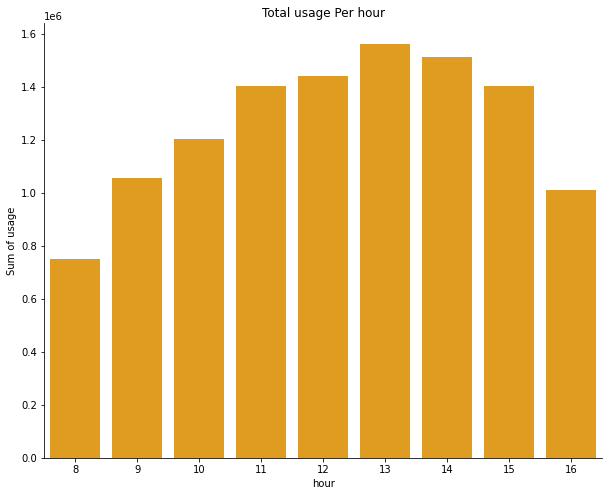

In [197]:
per_plot(df_filtre, feature=["hour","usage"])

,municipality_id,usage
0,0,713608
1,1,386091
2,2,628434
3,3,1396141
4,4,2987829
5,5,222954
6,6,1324190
7,7,1484174
8,8,1321968
9,9,867269


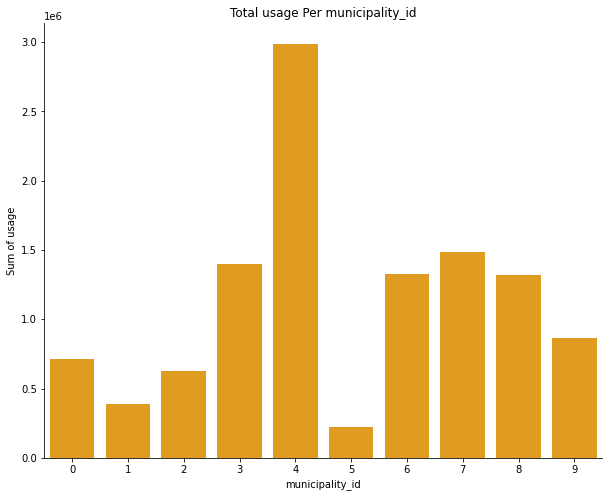

In [198]:
per_plot(df_filtre, feature=["municipality_id","usage"])

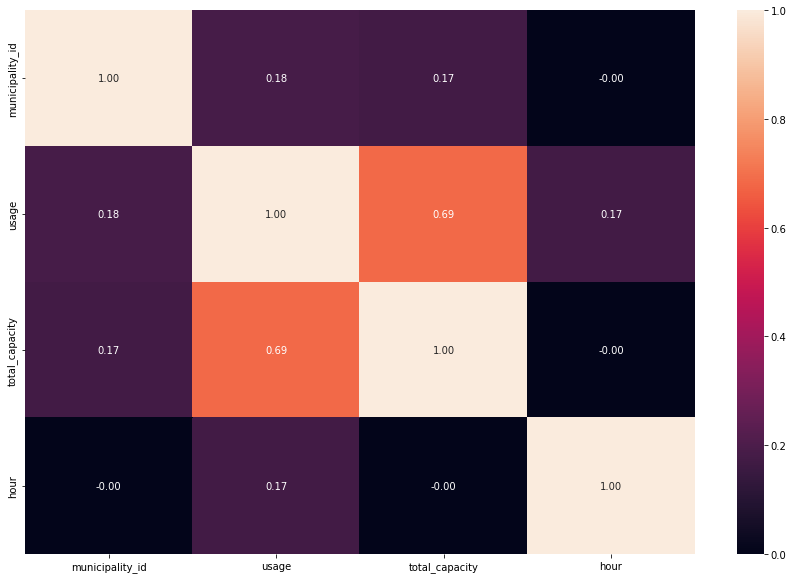

In [199]:
# Visualizing the Dataset variables and Correlation between them:
corr = df_filtre.corr()
fig, ax = plt.subplots(figsize = (15,10))

ax = sns.heatmap(corr, annot=True,
                 fmt='.2f')

In [200]:
metadata = df_filtre.groupby('date')['usage'].sum().reset_index()
metadata

,date,usage
0,2017-06-04,170503
1,2017-06-05,171854
2,2017-06-06,165668
3,2017-06-07,155895
4,2017-06-08,114807
...,...,...
67,2017-08-15,178511
68,2017-08-16,159068
69,2017-08-17,157445
70,2017-08-18,145982


In [201]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    72 non-null     object
 1   usage   72 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [202]:
time_col_df = metadata.set_index('date')
time_col_df

,usage
date,
2017-06-04,170503
2017-06-05,171854
2017-06-06,165668
2017-06-07,155895
2017-06-08,114807
...,...
2017-08-15,178511
2017-08-16,159068
2017-08-17,157445


In [203]:
def usage_time(data):
  data = data.copy()
  data.date = pd.to_datetime(data.date)
  n_of_days = data.date.max() - data.date.min()
  print(f"Start: {data.date.min()} \nEnd: {data.date.max()} \nDays: {n_of_days.days}")


In [204]:
usage_time(df_filtre)

Start: 2017-06-04 00:00:00 
End: 2017-08-19 00:00:00 
Days: 76


In [205]:
from statistics import mean

def avarage_2weeks(data):
  N = 14

  data = data.groupby('date')['usage'].sum().reset_index()
  data.date = pd.to_datetime(data.date)
  
  train_data = data[:-14] # use last two weeks as test data
  test_data = data[-14:]

  predictions = []
  for i in range(len(test_data)):
      past_N_days = train_data.iloc[-N:, -1]
      predictions.append(int(mean(past_N_days)))
      train_data = train_data.append(test_data.iloc[i])

  return predictions   
avarage_2weeks(metadata)

[166567,
 170205,
 170869,
 171414,
 170812,
 168283,
 165931,
 166946,
 169321,
 169314,
 169416,
 167750,
 165461,
 164050]

In [206]:
def seasonality_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.lineplot(x=x_col, y=y_col, data=data, ax=ax, color='darkblue', label='Total Usage')
    
    #data["date"] = pd.to_datetime(data["date"])
    #s_mean = data.groupby(data.date.dt.hour)[y_col].mean().reset_index()
    #s_mean.date = pd.to_datetime(s_mean.date, format='%d')
    #sns.lineplot((s_mean.date + datetime.timedelta(3*30/7)), y_col, data=s_mean, ax=ax, color='red', label='Mean Usage') 
    
    
    ax.set(xlabel = "Date",
           ylabel = "Usage",
           title = title)
    plt.show()


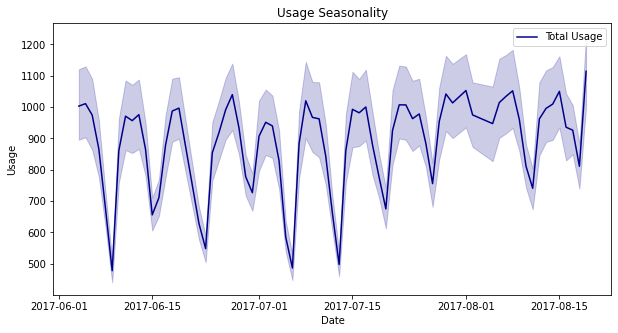

In [207]:
seasonality_plot(df_filtre, x_col='date', y_col='usage', title='Usage Seasonality')

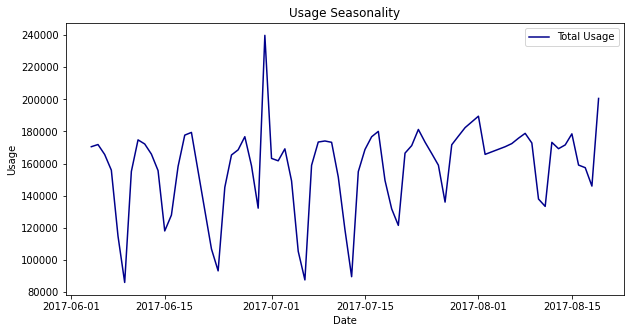

In [208]:
seasonality_plot(metadata, x_col='date', y_col='usage', title='Usage Seasonality')


In [209]:
def get_diff(data):
    """Calculate the difference in usage month over month:"""
    data['usage_diff'] = data.usage.diff()
    data = data.dropna()
    
    data.to_csv(f'{BASE_FILE}stationary_df.csv')
    
    return data

# try fourier transform !However, it's not necessary for ARIMA model, 
# which is a time series model that can be used for forecasting, as it 
# can handle non-stationary data as well.

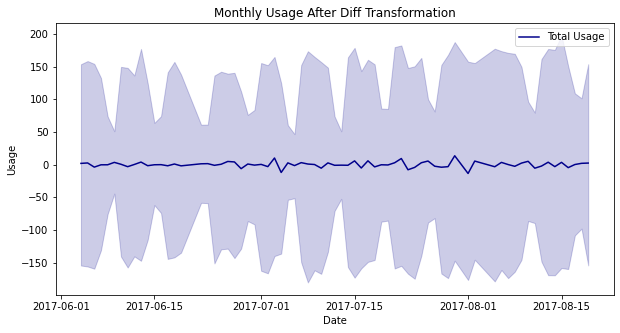

In [210]:
seasonality_plot(get_diff(df_filtre), 'date', 'usage_diff', 
          'Monthly Usage After Diff Transformation')

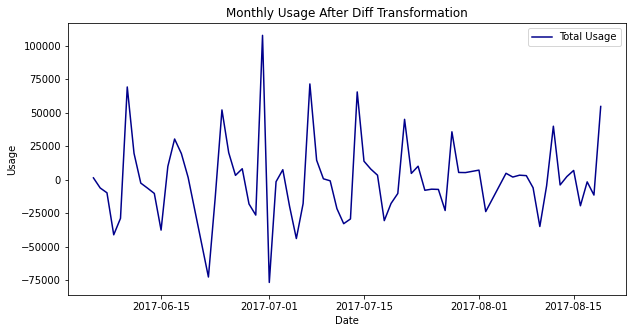

In [211]:
stationary_df = get_diff(metadata)
seasonality_plot(stationary_df, 'date', 'usage_diff', 
          'Monthly Usage After Diff Transformation')

In [212]:
stationary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 1 to 71
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        71 non-null     object 
 1   usage       71 non-null     int64  
 2   usage_diff  71 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


# ARIMA Modeling

In [213]:
def build_arima_data(data):
  data = data.copy()
  
  da_data = data.set_index('date').drop(['usage'], axis=1)
  da_data.dropna(axis=0)
  
  da_data.to_csv(f'{BASE_FILE}arima_df.csv')
  
  return da_data

In [214]:
datatime_df = build_arima_data(stationary_df)

datatime_df # ARIMA Dataframe


,usage_diff
date,
2017-06-05,1351.0
2017-06-06,-6186.0
2017-06-07,-9773.0
2017-06-08,-41088.0
2017-06-09,-28816.0
...,...
2017-08-15,6898.0
2017-08-16,-19443.0
2017-08-17,-1623.0


In [215]:
datatime_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71 entries, 2017-06-05 to 2017-08-19
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   usage_diff  71 non-null     float64
dtypes: float64(1)
memory usage: 1.1+ KB


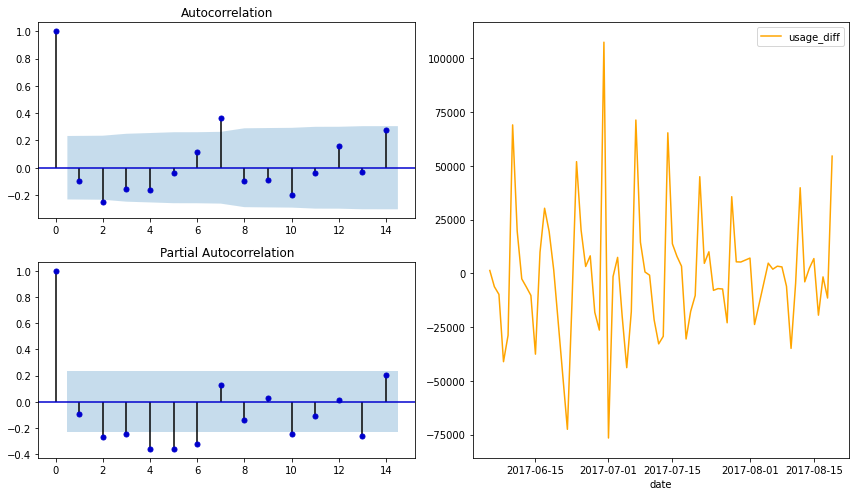

In [216]:
def plots_lag(data, lags=None):
    dt_data = data.set_index('date').drop('usage', axis=1)
    dt_data.dropna(axis=0)
    
    
    law  = plt.subplot(122)
    acf  = plt.subplot(221)
    pacf = plt.subplot(223)
    
    dt_data.plot(ax=law, figsize=(12, 7), color='orange')
    # Plot the autocorrelation function:
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    
    # Will also adjust spacing between subplots to minimize the overlaps:
    plt.tight_layout()

plots_lag(stationary_df, lags=14);

https://youtu.be/ZjaBn93YPWo
 The ACF plot shows the correlation between the time series and its lagged values, while the PACF plot shows the correlation between the time series and its lagged values, controlling for the intermediate lags.

# Regressive Modeling

In [217]:
def built_supervised(data,lag_num=[7,14]):
    supervised_df = data.copy()

    # Create column for each lag:
    for i in range(1, lag_num[0]+1):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['usage_diff'].shift(i)

    # Drop null values:
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    supervised_df.to_csv(f'{BASE_FILE}regressive_model_df.csv', index=False)
    
    return supervised_df

In [218]:
reg_model_df = built_supervised(stationary_df,lag_num=[7])
reg_model_df = reg_model_df[['date', 'usage', 'usage_diff', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7'] ]
reg_model_df # Supervised Dataframe

,date,usage,usage_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2017-06-12,172203,-2547.0,19647.0,69112.0,-28816.0,-41088.0,-9773.0,-6186.0,1351.0
1,2017-06-13,165891,-6312.0,-2547.0,19647.0,69112.0,-28816.0,-41088.0,-9773.0,-6186.0
2,2017-06-14,155641,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0,-41088.0,-9773.0
3,2017-06-15,118055,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0,-41088.0
4,2017-06-16,127914,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0
...,...,...,...,...,...,...,...,...,...,...
59,2017-08-15,178511,6898.0,2347.0,-3932.0,39861.0,-4586.0,-34889.0,-6003.0,3014.0
60,2017-08-16,159068,-19443.0,6898.0,2347.0,-3932.0,39861.0,-4586.0,-34889.0,-6003.0
61,2017-08-17,157445,-1623.0,-19443.0,6898.0,2347.0,-3932.0,39861.0,-4586.0,-34889.0
62,2017-08-18,145982,-11463.0,-1623.0,-19443.0,6898.0,2347.0,-3932.0,39861.0,-4586.0


In [219]:
reg_model_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        64 non-null     object 
 1   usage       64 non-null     int64  
 2   usage_diff  64 non-null     float64
 3   lag_1       64 non-null     float64
 4   lag_2       64 non-null     float64
 5   lag_3       64 non-null     float64
 6   lag_4       64 non-null     float64
 7   lag_5       64 non-null     float64
 8   lag_6       64 non-null     float64
 9   lag_7       64 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 5.1+ KB


**Train Test Split**

In [220]:
def train_test_split(data):
    data = data.drop(['usage','date'], axis=1)
    train , test = data[:-14].values, data[-14:].values
    print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}\nShape of Dataframe: {data.shape}")
    
    return train, test


In [221]:
"""def train_test_split(data):
  data.date = pd.to_datetime(data.date)
  test_data = data.loc[data["date"] >= pd.to_datetime(data['date'].max() - pd.DateOffset(weeks=2))]
  test = test_data.values
  train_data = data.loc[data["date"] < pd.to_datetime(data['date'].max() - pd.DateOffset(weeks=2))]
  train = train_data.values
  data = data.drop(['usage','date'], axis=1)
  print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}\nShape of Dataframe: {data.shape}")
  return train, test"""


'def train_test_split(data):\n  data.date = pd.to_datetime(data.date)\n  test_data = data.loc[data["date"] >= pd.to_datetime(data[\'date\'].max() - pd.DateOffset(weeks=2))]\n  test = test_data.values\n  train_data = data.loc[data["date"] < pd.to_datetime(data[\'date\'].max() - pd.DateOffset(weeks=2))]\n  train = train_data.values\n  data = data.drop([\'usage\',\'date\'], axis=1)\n  print(f"Shape of  Train: {train.shape}\nShape of  Test: {test.shape}\nShape of Dataframe: {data.shape}")\n  return train, test'

In [222]:
train, test = train_test_split(reg_model_df)

Shape of  Train: (50, 8)
Shape of  Test: (14, 8)
Shape of Dataframe: (64, 8)


**Scale The Data**

In [223]:
def scale_data(train_set,test_set):
    """Scales data using MinMaxScaler and separates data into X_train, y_train,
    X_test, and y_test."""
    
    # Apply Min Max Scaler:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # Reshape training set:
    train_set = train_set.reshape(train_set.shape[0],
                                  train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # Reshape test set:
    test_set = test_set.reshape(test_set.shape[0], 
                                test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel() # returns the array, flattened!
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler


In [224]:
X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
print(f"Shape of X Train: {X_train.shape}\nShape of y Train: {y_train.shape}\nShape of X Test: {X_test.shape}\nShape of y Test: {y_test.shape}")


Shape of X Train: (50, 7)
Shape of y Train: (50,)
Shape of X Test: (14, 7)
Shape of y Test: (14,)


**Reverse Scaling**

In [225]:
def re_scaling(y_pred, x_test, scaler_obj, lstm=False):
    """For visualizing and comparing results, undoes the scaling effect on predictions."""
   # y_pred: model predictions
   # x_test: features from the test set used for predictions
   # scaler_obj: the scaler objects used for min-max scaling
   # lstm: indicate if the model run is the lstm. If True, additional transformation occurs 
    
    # Reshape y_pred:
    y_pred = y_pred.reshape(y_pred.shape[0],
                            1,
                            1)

    if not lstm:
        x_test = x_test.reshape(x_test.shape[0],
                                1, 
                                x_test.shape[1])

    # Rebuild test set for inverse transform:
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], 
                                             x_test[index]],
                                             axis=1) )

    # Reshape pred_test_set:
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    # Inverse transform:
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)

    return pred_test_set_inverted

**Predictions Dataframe**

In [226]:
def prediction_df(unscale_predictions, origin_df):
    """Generates a dataframe that shows the predicted usage for each month
    for plotting results."""
    
    # unscale_predictions: the model predictions that do not have min-max or other scaling applied
    # origin_df: the original metadata dataframe
    
    # Create dataframe that shows the predicted usage:
    result_list = []
    usage_dates = list(origin_df[-15:].date)
    act_usage = list(origin_df[-15:].usage)

    for index in range(0, len(unscale_predictions)):
        result_dict = {}
        if index + 1 >= len(usage_dates):
          # Handle index out of range error
          continue
        else:
          result_dict['pred_value'] = int(unscale_predictions[index][0] + act_usage[index])
          result_dict['date'] = usage_dates[index + 1]
        
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

**Score The Models**

In [227]:
model_scores = {}

def get_scores(unscale_df, origin_df, model_name):
    """Prints the root mean squared error, mean absolute error, and r2 scores
    for each model. Saves all results in a model_scores dictionary for
    comparison."""
    
    rmse = np.sqrt(mean_squared_error(origin_df.usage[-14:], unscale_df.pred_value[-14:]))
    
    mae = mean_absolute_error(origin_df.usage[-14:], unscale_df.pred_value[-14:])
    
    r2 = r2_score(origin_df.usage[-14:], unscale_df.pred_value[-14:])
    
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")

**Graph of Results**

In [228]:
def plot_results(results, origin_df, model_name):
# results: a dataframe with unscaled predictions

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(origin_df.date, origin_df.usage, data=origin_df, ax=ax, 
                 label='Original', color='blue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='red')
    
    
    ax.set(xlabel = "Date",
           ylabel = "Usage",
           title = f"{model_name} Usage Forecasting Prediction")
    
    ax.legend(loc='best')
    
    filepath = Path(f'{BASE_FILE}model_output/{model_name}_forecasting.svg')  
    filepath.parent.mkdir(parents=True, exist_ok=True) 
    plt.savefig(f'{BASE_FILE}model_output/{model_name}_forecasting.svg')

**Modeling**

In [229]:
def regressive_model(train_data, test_data, model, model_name):
    """Runs regressive models in SKlearn framework. First calls scale_data
    to split into X and y and scale the data. Then fits and predicts. Finally,
    predictions are unscaled, scores are printed, and results are plotted and
    saved."""
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data,
                                                                 test_data)

    # Run sklearn models:
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test) # y_pred=predictions

    # Undo scaling to compare predictions against original data:
    origin_df = metadata
    unscaled = re_scaling(predictions, X_test, scaler_object) # unscaled_predictions
    unscaled_df = prediction_df(unscaled, origin_df)

    # Print scores and plot results:
    get_scores(unscaled_df, origin_df, model_name)
    plot_results(unscaled_df, origin_df, model_name)



*   Linear Regression

*   XGBoost
*    LSTM




RMSE: 17053.767828338026
MAE: 12685.42857142857
R2 Score: 0.023327694735970406


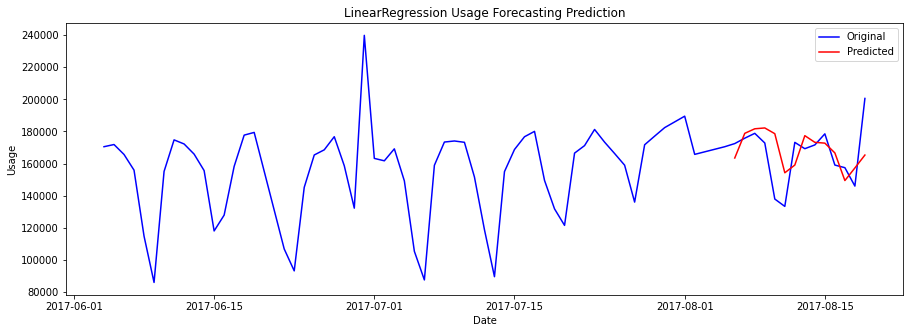

In [230]:
regressive_model(train, test, LinearRegression(), 'LinearRegression')

RMSE: 19788.0362430723
MAE: 15049.642857142857
R2 Score: -0.31496312693968465


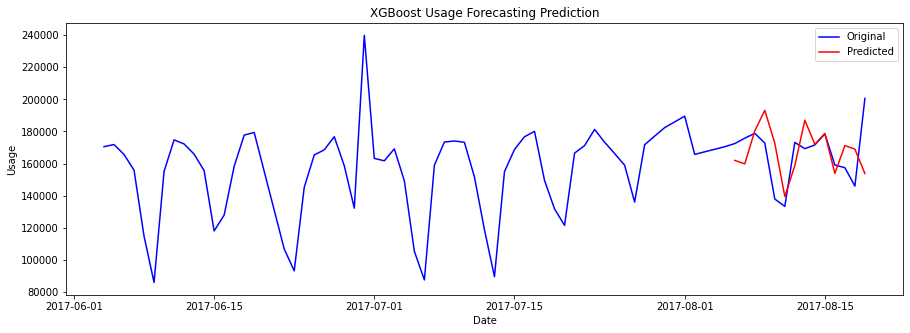

In [231]:
regressive_model(train, test, XGBRegressor(n_estimators=50,max_depth=3, 
                                           learning_rate=0.4,objective='reg:squarederror'), 'XGBoost')

**LSTM**

In [267]:
def lstm_model(train_data, test_data):
    """Runs a long-short-term-memory neural net with 2 dense layers. 
    Generates predictions that are then unscaled. 
    Scores are printed and the results are plotted and saved."""
    # train_data: dataset used to train the model
    # test_data: dataset used to test the model
   
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_test)
    
    # Build LSTM:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=2, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    # Undo scaling to compare predictions against original data:
    origin_df = metadata
    unscaled = re_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = prediction_df(unscaled, origin_df)
    
    get_scores(unscaled_df, origin_df, 'LSTM')
    plot_results(unscaled_df, origin_df, 'LSTM')
    

Epoch 1/100
50/50 - 2s - loss: 0.1209 - accuracy: 0.0000e+00 - 2s/epoch - 36ms/step
Epoch 2/100
50/50 - 0s - loss: 0.1089 - accuracy: 0.0000e+00 - 83ms/epoch - 2ms/step
Epoch 3/100
50/50 - 0s - loss: 0.1065 - accuracy: 0.0000e+00 - 105ms/epoch - 2ms/step
Epoch 4/100
50/50 - 0s - loss: 0.1044 - accuracy: 0.0000e+00 - 85ms/epoch - 2ms/step
Epoch 5/100
50/50 - 0s - loss: 0.1023 - accuracy: 0.0000e+00 - 90ms/epoch - 2ms/step
Epoch 6/100
50/50 - 0s - loss: 0.1004 - accuracy: 0.0000e+00 - 82ms/epoch - 2ms/step
Epoch 7/100
50/50 - 0s - loss: 0.0985 - accuracy: 0.0000e+00 - 81ms/epoch - 2ms/step
Epoch 8/100
50/50 - 0s - loss: 0.0967 - accuracy: 0.0000e+00 - 99ms/epoch - 2ms/step
Epoch 9/100
50/50 - 0s - loss: 0.0950 - accuracy: 0.0000e+00 - 85ms/epoch - 2ms/step
Epoch 10/100
50/50 - 0s - loss: 0.0934 - accuracy: 0.0000e+00 - 82ms/epoch - 2ms/step
Epoch 11/100
50/50 - 0s - loss: 0.0919 - accuracy: 0.0000e+00 - 85ms/epoch - 2ms/step
Epoch 12/100
50/50 - 0s - loss: 0.0906 - accuracy: 0.0000e+00 -

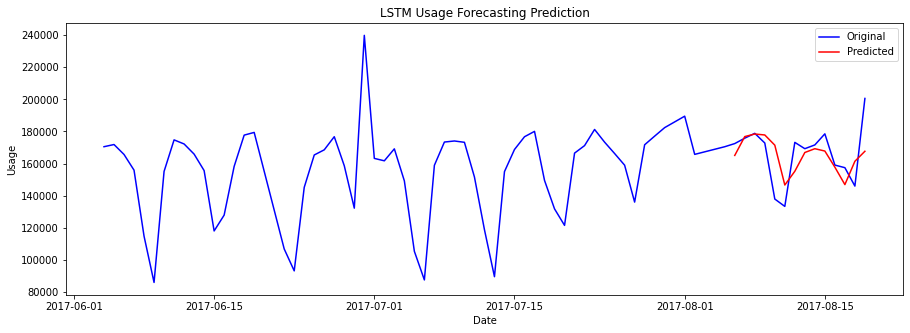

In [233]:
lstm_model(train,test)

In [234]:
url_reg_model = "model_scores"
pickle.dump(model_scores, open( f"{BASE_FILE}{url_reg_model}.p", "wb" ))

**ARIMA Modeling**

An extension to ARIMA that supports the direct modeling of the seasonal component of the series is called SARIMAX.


In [235]:
datatime_df.index = pd.to_datetime(datatime_df.index)

In [236]:
def sarimax_model(data):
    # Model:
    sar = sm.tsa.statespace.SARIMAX(data.usage_diff, order=(7, 0, 0),#(p,d,q)
                                    seasonal_order=(0, 1, 0, 7), #(P,D,Q,m)
                                    trend='c').fit()
    print(sar.summary())
    
    # Generate predictions:
    start, end, dynamic = 56, 70, True
    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)
    pred_df = data.pred_value[start+dynamic:end]
    
    data[["usage_diff","pred_value"]].plot(color=['blue', 'Red'], figsize=(15,5))
    plt.legend(loc='upper left')
    
    model_score = {}
    
    rmse = np.sqrt(mean_squared_error(data.usage_diff[-14:], data.pred_value[-14:]))
    mae = mean_absolute_error(data.usage_diff[-14:], data.pred_value[-14:])
    r2 = r2_score(data.usage_diff[-14:], data.pred_value[-14:])
    model_scores['ARIMA'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")
    
    return sar, data, pred_df


                                     SARIMAX Results                                     
Dep. Variable:                        usage_diff   No. Observations:                   71
Model:             SARIMAX(7, 0, 0)x(0, 1, 0, 7)   Log Likelihood                -740.529
Date:                           Thu, 26 Jan 2023   AIC                           1499.059
Time:                                   19:45:34   BIC                           1518.489
Sample:                                        0   HQIC                          1506.713
                                            - 71                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    170.9244   5019.893      0.034      0.973   -9667.885       1e+04
ar.L1         -0.2090      0.103     -2.022

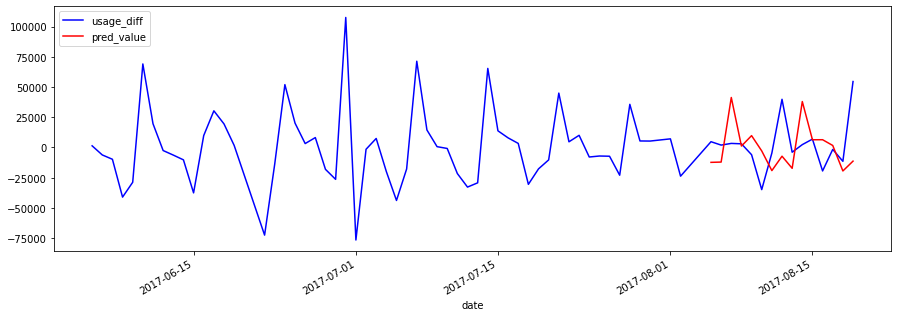

In [237]:
# run SARIMAX model
sar, datatime_df, predictions = sarimax_model(datatime_df)

In [238]:
"""def print_params(s):
    from io import StringIO

    return pd.read_csv(StringIO(s.tables[1].as_csv()), index_col=0)


print_params(sar.summary())"""

'def print_params(s):\n    from io import StringIO\n\n    return pd.read_csv(StringIO(s.tables[1].as_csv()), index_col=0)\n\n\nprint_params(sar.summary())'

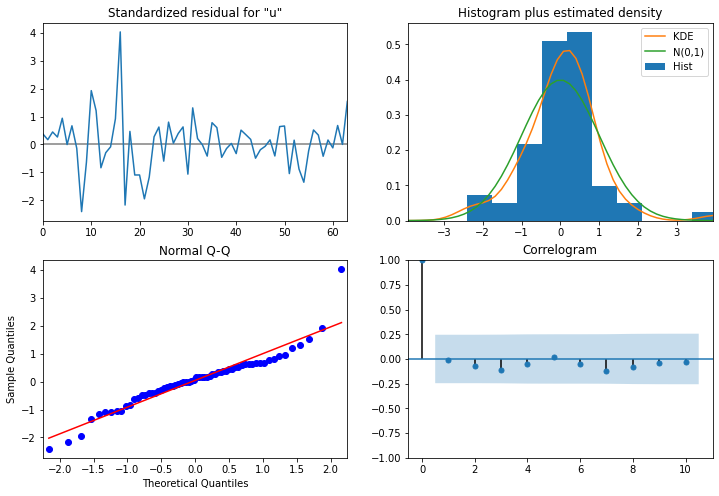

In [239]:
sar.plot_diagnostics(figsize=(12, 8));

In [240]:
url_arima = "ARIMAmodel_scores"
pickle.dump(model_scores, open( f"{BASE_FILE}{url_arima}.p", "wb" ))

In [241]:
def create_results_df(*args):
    results_dict = {}
    for url in args:
        results_dict.update(pickle.load(open(f'{BASE_FILE}{url}.p', "rb")))

    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index', 
                                        columns=['RMSE', 'MAE','R2'])
    
    results_df = results_df.sort_values(by='RMSE', ascending=False).reset_index()
    
    
    results_df.to_csv(f'{BASE_FILE}{results_dict.keys()}.csv')

    
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.lineplot(np.arange(len(results_df)), 'RMSE', data=results_df, ax=ax, 
                 label='RMSE', color='darkblue')
    sns.lineplot(np.arange(len(results_df)), 'MAE', data=results_df, ax=ax, 
                 label='MAE', color='Cyan')
    
    plt.xticks(np.arange(len(results_df)),rotation=45)
    ax.set_xticklabels(results_df['index'])
    ax.set(xlabel = "Model",
           ylabel = "Scores",
           title = "Model Error Comparison")
    sns.despine()
    
    plt.savefig(f'{BASE_FILE}model_output/compare_models_{{"_".join(args)}}.png')
    
    return results_df

,index,RMSE,MAE,R2
0,ARIMA,29131.887209,22562.418245,-0.862047
1,XGBoost,19788.036243,15049.642857,-0.314963
2,LinearRegression,17053.767828,12685.428571,0.023328
3,LSTM,15272.104364,11017.285714,0.216740


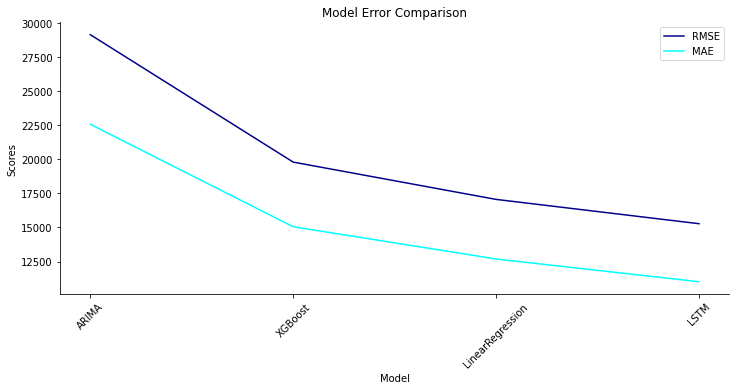

In [242]:
results = create_results_df(url_reg_model, url_arima)
results

In [243]:
avarage = avarage_2weeks(metadata)
mean = np.mean(avarage)
mean

168309.92857142858

In [244]:
LSTM = results.MAE.values[2]
linear_reg = results.MAE.values[3]
percentage_off = round(LSTM/mean*100,2)
percentage_off1 = round(linear_reg/mean*100,2)
print(f"With LSTM, prediction is within {percentage_off}% of the actual.\nWith LinearRegression, prediction is within {percentage_off1}% of the actual.")


With LSTM, prediction is within 7.54% of the actual.
With LinearRegression, prediction is within 6.55% of the actual.


# Hyperparameter Tunings

In [245]:
reg_modelHyp_df = built_supervised(stationary_df,lag_num=[14])
reg_modelHyp_df

,date,usage,usage_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
0,2017-06-19,179396,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0,-41088.0,-9773.0,-6186.0,1351.0
1,2017-06-22,106842,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0,-41088.0,-9773.0,-6186.0
2,2017-06-23,93200,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0,-41088.0,-9773.0
3,2017-06-24,145200,52000.0,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0,-41088.0
4,2017-06-25,165345,20145.0,52000.0,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0,-28816.0
5,2017-06-26,168561,3216.0,20145.0,52000.0,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0,69112.0
6,2017-06-27,176736,8175.0,3216.0,20145.0,52000.0,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0,19647.0
7,2017-06-28,158625,-18111.0,8175.0,3216.0,20145.0,52000.0,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0,-2547.0
8,2017-06-29,132240,-26385.0,-18111.0,8175.0,3216.0,20145.0,52000.0,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0,-6312.0
9,2017-06-30,239826,107586.0,-26385.0,-18111.0,8175.0,3216.0,20145.0,52000.0,-13642.0,-72554.0,1689.0,19470.0,30323.0,9859.0,-37586.0,-10250.0


In [246]:
train_hyp, test_hyp = train_test_split(reg_modelHyp_df)

Shape of  Train: (43, 15)
Shape of  Test: (14, 15)
Shape of Dataframe: (57, 15)


In [247]:
X_train1, y_train1, X_test1, y_test1, scaler_object1 = scale_data(train_hyp, test_hyp)
print(f"Shape of X Train: {X_train1.shape}\nShape of y Train: {y_train1.shape}\nShape of X Test: {X_test1.shape}\nShape of y Test: {y_test1.shape}")

Shape of X Train: (43, 14)
Shape of y Train: (43,)
Shape of X Test: (14, 14)
Shape of y Test: (14,)


**LR**

In [248]:
def lr_gridsearch():
  param_grid = {'fit_intercept': [True, False],
                'normalize': [True, False],
                'n_jobs': [-1, 1],
                }
  lr = LinearRegression()
  grid_search = GridSearchCV(lr, param_grid, cv=5)
  grid_search.fit(X_train, y_train)

  print(f"Best parameters: {grid_search.best_params_}")
  print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

lr_gridsearch()

Best parameters: {'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
Best cross-validation score: 0.13


RMSE: 17053.767828338026
MAE: 12685.42857142857
R2 Score: 0.023327694735970406


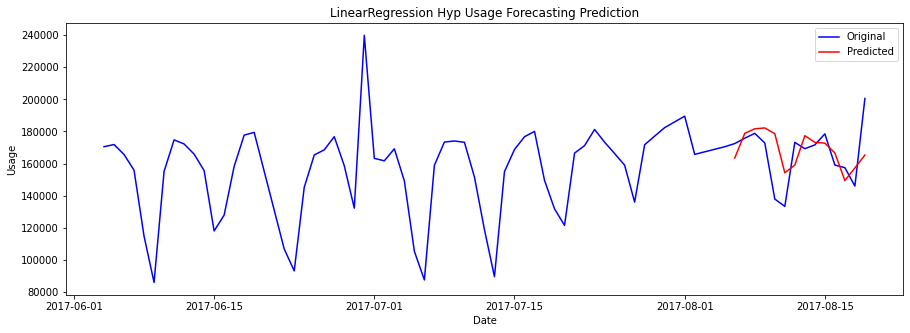

In [249]:
regressive_model(train, test, LinearRegression(fit_intercept= True, n_jobs=-1, normalize=False), 'LinearRegression Hyp')

RMSE: 16379.365248036062
MAE: 13029.5
R2 Score: 0.0990466269381296


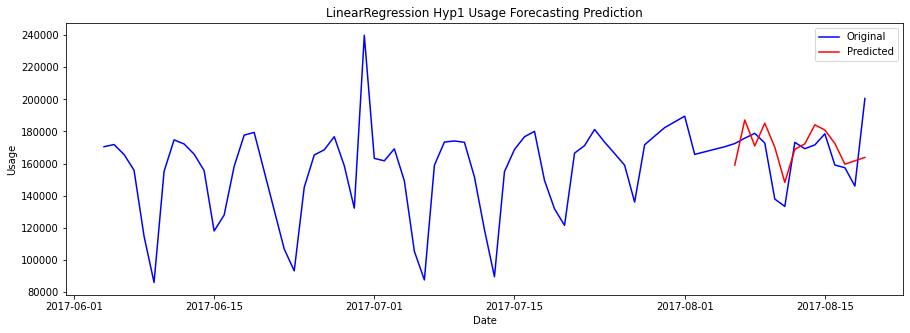

In [250]:
regressive_model(train_hyp, test_hyp, LinearRegression(fit_intercept= True, n_jobs=-1, normalize=False), 'LinearRegression Hyp1')

**XGBoost**

In [251]:
def grid_search_xgboost(X_train, y_train, param_grid, cv=5):
    xgb = XGBRegressor(objective ='reg:squarederror', verbosity = 0, random_state=42)
    grid_search = GridSearchCV(xgb, param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    return grid_search

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'reg_lambda': [0.1, 1, 10],
    'reg_alpha': [0, 0.1, 1],
}

grid_search_result = grid_search_xgboost(X_train, y_train, param_grid)
best_params = grid_search_result.best_params_
print(best_params)

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 10}


RMSE: 21053.086353311715
MAE: 14186.0
R2 Score: -0.4884687604785256


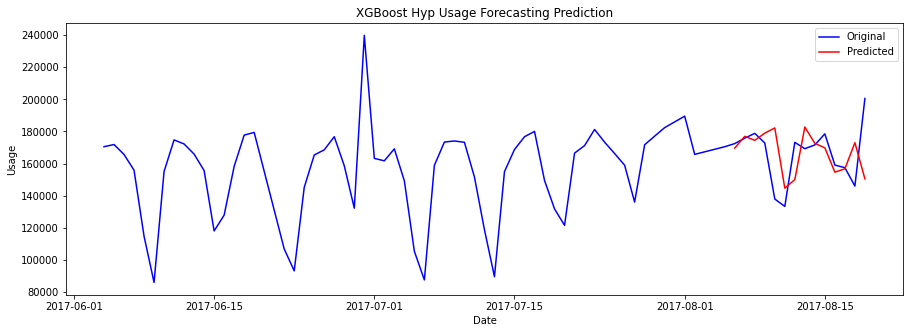

In [252]:
regressive_model(train, test, XGBRegressor(n_estimators=500,max_depth=3, 
                                           learning_rate=0.01,objective='reg:squarederror', reg_alpha= 0.1, reg_lambda=10), 'XGBoost Hyp')

RMSE: 19138.184071939235
MAE: 12718.42857142857
R2 Score: -0.23001281240759086


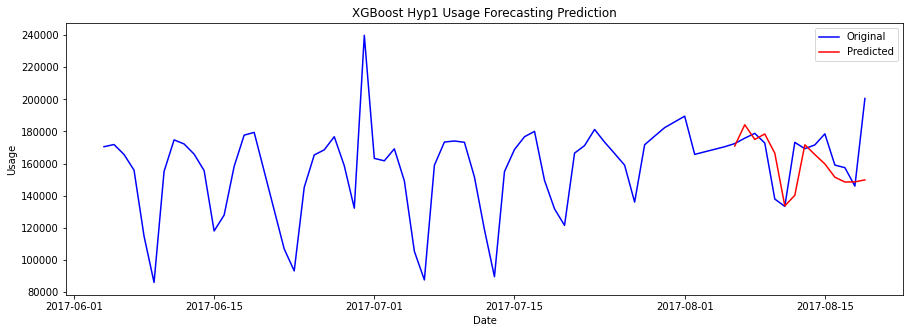

In [253]:
regressive_model(train_hyp, test_hyp, XGBRegressor(n_estimators=500,max_depth=3, 
                                           learning_rate=0.01,objective='reg:squarederror', reg_alpha= 0.1, reg_lambda=10), 'XGBoost Hyp1')

**LSTM**

In [254]:
"""
def lstm_gridsearch(train_data, test_data):

    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
  
    print(X_train.shape[1], X_train.shape[2])
    batch_size = [32, 64, 128]
    epochs = [50, 100, 150]
   

    # Initialize best_score to a large negative number
    best_score = -np.inf

    # Initialize best_params to None
    best_params = None

    for bs in batch_size:
        for e in epochs:
            model = Sequential()
            model.add(LSTM(10, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])
            , return_sequences=True))
            model.add(Dense(1))
            model.add(Dense(1))
            model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=e, batch_size=bs, verbose=2, 
                      shuffle=False)
            predictions = model.predict(test_data,batch_size=bs)
            
            scores = model.evaluate(test_data, test_data, verbose=0)
            if scores[1] > best_score:
                best_score = scores[1]
                best_params = (bs, e)

    return best_params
"""

"\ndef lstm_gridsearch(train_data, test_data):\n\n    # Split into X & y and scale data:\n    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)\n\n    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])\n    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])\n  \n    print(X_train.shape[1], X_train.shape[2])\n    batch_size = [32, 64, 128]\n    epochs = [50, 100, 150]\n   \n\n    # Initialize best_score to a large negative number\n    best_score = -np.inf\n\n    # Initialize best_params to None\n    best_params = None\n\n    for bs in batch_size:\n        for e in epochs:\n            model = Sequential()\n            model.add(LSTM(10, batch_input_shape=(1, X_train.shape[1], X_train.shape[2])\n            , return_sequences=True))\n            model.add(Dense(1))\n            model.add(Dense(1))\n            model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])\n            model.fit(X_train, y_train, epochs=e, batch

In [255]:
#lstm_gridsearch(train, test)

In [256]:
"""
from keras.wrappers.scikit_learn import KerasRegressor

param_grid = {'batch_size': [32, 64, 128],
              'epochs': [50, 100, 150],
              'optimizer': ['adam', 'rmsprop'],
              'loss': ['mean_squared_error', 'mean_absolute_error']
              }
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
    return model

lstm = KerasRegressor(build_fn=build_lstm_model)

grid_search = GridSearchCV(lstm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print("Best cross-validation score: {grid_search.best_score_:.2f}")
"""

'\nfrom keras.wrappers.scikit_learn import KerasRegressor\n\nparam_grid = {\'batch_size\': [32, 64, 128],\n              \'epochs\': [50, 100, 150],\n              \'optimizer\': [\'adam\', \'rmsprop\'],\n              \'loss\': [\'mean_squared_error\', \'mean_absolute_error\']\n              }\ndef build_lstm_model():\n    model = Sequential()\n    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), \n                   stateful=True))\n    model.add(Dense(1))\n    model.add(Dense(1))\n    model.compile(loss=\'mse\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    \n    return model\n\nlstm = KerasRegressor(build_fn=build_lstm_model)\n\ngrid_search = GridSearchCV(lstm, param_grid, cv=5)\ngrid_search.fit(X_train, y_train)\n\nprint(f"Best parameters: {grid_search.best_params_}")\nprint("Best cross-validation score: {grid_search.best_score_:.2f}")\n'

In [257]:
"""
def lstm_model(train_data, test_data):
    
   
    
    # Split into X & y and scale data:
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print(X_test)
    
    # Build LSTM:
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=RMSprop(lr=0.1), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=150, batch_size=1, verbose=2, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    # Undo scaling to compare predictions against original data:
    origin_df = metadata
    unscaled = re_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = prediction_df(unscaled, origin_df)
    
    get_scores(unscaled_df, origin_df, 'LSTM Hyp1')
    plot_results(unscaled_df, origin_df, 'LSTM Hyp1')
    """

In [259]:
#lstm_model_final(train,test)

ValueError: ignored

In [260]:
url_model_final = "model_final_scores"
pickle.dump(model_scores, open(f"{BASE_FILE}{url_model_final}.p" , "wb" ))

**SARIMAX**

In [261]:
#!pip install skforecast

In [262]:
"""from skforecast.model_selection_statsmodels import grid_search_sarimax

param_grid = {'order': [(7, 0, 0), (7, 2, 0), (7, 1, 0), (7, 1, 1), (14, 1, 4)],
             'seasonal_order': [(0, 0, 0, 0)],
             'trend': [None, 'n', 'c']}
results_grid = grid_search_sarimax(y= datatime_df['usage_diff'],
                param_grid = param_grid,
                initial_train_size = len(y_train),
                fixed_train_size = False,
                steps = 7,
                metric = 'mean_absolute_error',
                refit = False,
                verbose = False,
                fit_kwargs = {'maxiter': 50, 'disp': 0}
               )

results_grid"""

"from skforecast.model_selection_statsmodels import grid_search_sarimax\n\nparam_grid = {'order': [(7, 0, 0), (7, 2, 0), (7, 1, 0), (7, 1, 1), (14, 1, 4)],\n             'seasonal_order': [(0, 0, 0, 0)],\n             'trend': [None, 'n', 'c']}\nresults_grid = grid_search_sarimax(y= datatime_df['usage_diff'],\n                param_grid = param_grid,\n                initial_train_size = len(y_train),\n                fixed_train_size = False,\n                steps = 7,\n                metric = 'mean_absolute_error',\n                refit = False,\n                verbose = False,\n                fit_kwargs = {'maxiter': 50, 'disp': 0}\n               )\n\nresults_grid"

In [263]:
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
#trends = ('n','c','t','ct') #. 'c' değeri, sadece sabit bir trendi kullanırken, 't' değeri, sadece doğrusal bir trendi kullanır. 'n' değeri trend olmadan tahmin yapar ve 'ct' değeri hem sabit hem de doğrusal trendi

def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50): #add trend
 
    ans = []
    for comb in pdq:
        for combs in pdqs:
          #for t in trends:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts.usage_diff, order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                #trend= t
                                                )

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic]) # add t 
                #print('SARIMAX {} x {}7 trend {}: BIC Calculated ={}'.format(comb, combs, t, output.bic))#4*27*27 = 2916 range(0,3)and len(trend)=4 
            except:
                continue
            
   #bic (Bayesian Information Criterion) Daha düşük BIC değerleri, daha iyi uyumlu olduğu anlamına gelir.
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:2]
    
    return ans_df
    
sarimax_gridsearch(datatime_df, pdq, pdqs) # add trends

,pdq,pdqs,bic
638,"(2, 1, 2)","(1, 2, 2, 7)",29.308493
701,"(2, 2, 1)","(2, 2, 2, 7)",29.308493


                                     SARIMAX Results                                     
Dep. Variable:                        usage_diff   No. Observations:                   71
Model:             SARIMAX(2, 1, 2)x(1, 2, 2, 7)   Log Likelihood                -672.813
Date:                           Thu, 26 Jan 2023   AIC                           1363.627
Time:                                   20:13:31   BIC                           1381.855
Sample:                                        0   HQIC                          1370.694
                                            - 71                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.3260    422.616     -0.008      0.994    -831.638     824.986
ar.L1          0.7097      0.405      1.750

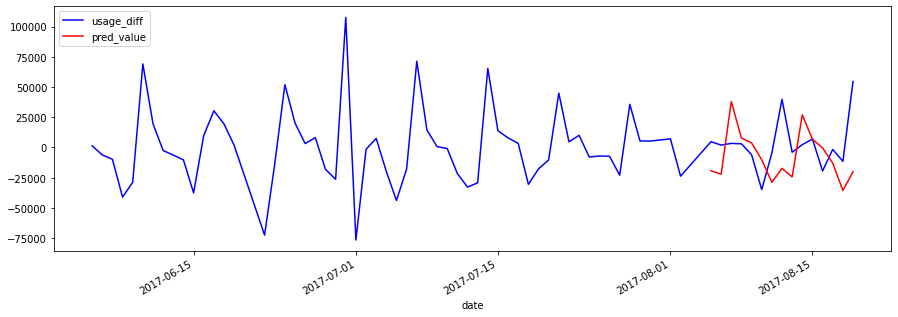

In [268]:
def sarimax_model_final(data):
    # Model:
    sar = sm.tsa.statespace.SARIMAX(data.usage_diff, order=(2, 1, 2),#(p,d,q)
                                    seasonal_order=(1, 2, 2, 7), #(P,D,Q,m)
                                    trend='c').fit()
    print(sar.summary())
    
    # Generate predictions:
    start, end, dynamic = 56, 70, True
    data['pred_value'] = sar.predict(start=start, end=end, dynamic=dynamic)
    pred_df = data.pred_value[start+dynamic:end]
    
    data[["usage_diff","pred_value"]].plot(color=['blue', 'Red'], figsize=(15,5))
    plt.legend(loc='upper left')
    
    model_score = {}
    
    rmse = np.sqrt(mean_squared_error(data.usage_diff[-14:], data.pred_value[-14:]))
    mae = mean_absolute_error(data.usage_diff[-14:], data.pred_value[-14:])
    r2 = r2_score(data.usage_diff[-14:], data.pred_value[-14:])
    model_scores['ARIMA Hyp'] = [rmse, mae, r2]
    
    print(f"RMSE: {rmse}\nMAE: {mae}\nR2 Score: {r2}")
    
    return sar, data, pred_df

sar, datatime_df, predictions = sarimax_model_final(datatime_df)


In [269]:
url_arima_final = "arima_model_final"
pickle.dump(model_scores, open(f"{BASE_FILE}{url_arima_final}.p" , "wb" ))

,index,RMSE,MAE,R2
0,ARIMA Hyp,31681.873850,25291.368532,-1.202293
1,ARIMA,29131.887209,22562.418245,-0.862047
2,XGBoost Hyp,21053.086353,14186.000000,-0.488469
3,XGBoost,19788.036243,15049.642857,-0.314963
4,XGBoost Hyp1,19138.184072,12718.428571,-0.230013
5,LinearRegression,17053.767828,12685.428571,0.023328
6,LinearRegression Hyp,17053.767828,12685.428571,0.023328
7,LinearRegression Hyp1,16379.365248,13029.500000,0.099047
8,LSTM,15272.104364,11017.285714,0.216740


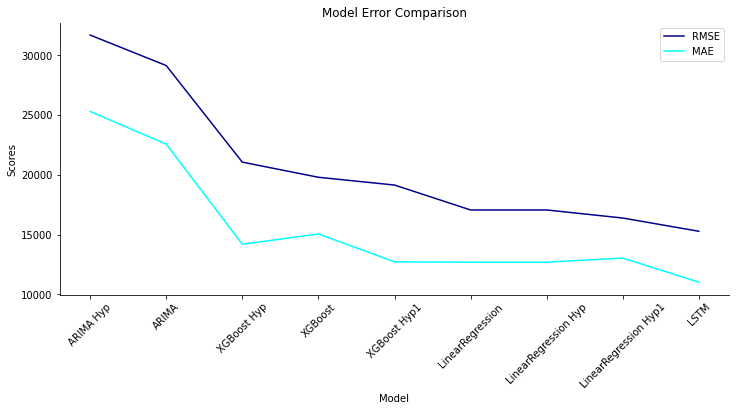

In [270]:
create_results_df(url_arima_final, url_model_final, url_arima, url_reg_model)